In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

path = "/content/drive/My Drive/DL"
os.listdir(path)


['train.csv',
 'sample_submission.csv',
 'test.csv',
 'test_labels.csv',
 'bert_toxic_model']

In [3]:
import pandas as pd

# Load the training data
df = pd.read_csv("/content/drive/My Drive/DL/train.csv")

# Show first 5 rows
print("First 5 rows:")
display(df.head())

# Show columns
print("\nColumns in the dataset:")
print(df.columns)

# Show dataset info
print("\nDataset info:")
print(df.info())

# Number of rows
print("\nNumber of rows:", len(df))


First 5 rows:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0



Columns in the dataset:
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None

Number of rows: 159571


In [4]:
# Create a binary label: toxic OR not toxic
df["toxic_binary"] = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].max(axis=1)

# Check the first few rows
df[["comment_text", "toxic_binary"]].head()


,comment_text,toxic_binary
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
from sklearn.model_selection import train_test_split

# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["comment_text"].values,
    df["toxic_binary"].values,
    test_size=0.2,
    random_state=42
)

print("Training samples:", len(train_texts))
print("Testing samples:", len(test_texts))


Training samples: 127656
Testing samples: 31915


In [6]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Test the tokenizer on one example
test_text = "You are an idiot."
tokens = tokenizer.tokenize(test_text)
ids = tokenizer.convert_tokens_to_ids(tokens)

print("Tokens:", tokens)
print("Token IDs:", ids)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokens: ['you', 'are', 'an', 'idiot', '.']
Token IDs: [2017, 2024, 2019, 10041, 1012]


In [7]:
import torch
from torch.utils.data import Dataset

class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [8]:
sample = ToxicCommentsDataset(train_texts, train_labels, tokenizer)[0]
sample


{'input_ids': tensor([  101, 13055, 26568,  2323,  6402,  1999, 11669, 13055, 26568,  2003,
         11669,  1012,  1045,  5223, 13055, 26568,  1012,  1042,  1003,  1003,
          1047,  2014,  2000,  3109,   999,  6390,  1012,  6356,  1012,  6146,
          1012,  2871,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [9]:
from torch.utils.data import DataLoader

# Create dataset objects
train_dataset = ToxicCommentsDataset(train_texts, train_labels, tokenizer, max_len=128)
test_dataset = ToxicCommentsDataset(test_texts, test_labels, tokenizer, max_len=128)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Train loader batches:", len(train_loader))
print("Test loader batches:", len(test_loader))


Train loader batches: 7979
Test loader batches: 1995


In [10]:
from transformers import BertForSequenceClassification

# Load BERT with a classification head
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

device


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device(type='cuda')

In [11]:
import torch
torch.device("cuda" if torch.cuda.is_available() else "cpu")


device(type='cuda')

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm  # Progress bar

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 2  # You can increase to 3 if needed

model.train()

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        # Move data to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_loss:.4f}")


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

# Put model in evaluation mode
model.eval()

all_preds = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.410841297195676
Precision: 0.06964651214250152
Recall: 0.38810110974106043
F1 Score: 0.11809952628863561


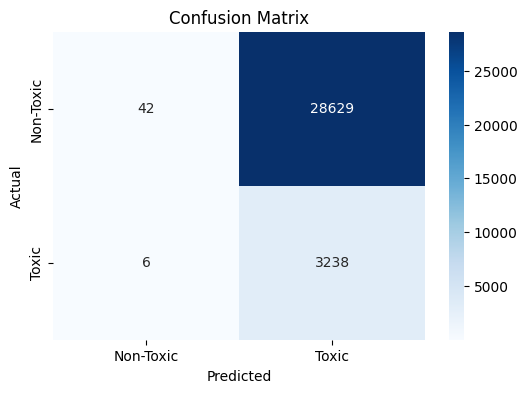

array([[   42, 28629],
       [    6,  3238]])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Toxic", "Toxic"],
            yticklabels=["Non-Toxic", "Toxic"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

cm


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

model_path = "/content/drive/My Drive/DL/bert_toxic_model"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Move model to GPU if available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import torch.nn.functional as F

def predict_toxicity(text):
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        probability = probs[0][predicted_class].item()

    label = "Toxic" if predicted_class == 1 else "Not Toxic"
    return label, probability


In [ ]:
print(predict_toxicity("I hate you, you stupid idiot!"))
print(predict_toxicity("You are an amazing person, have a great day!"))
print(predict_toxicity("Shut up, you clown."))
print(predict_toxicity("I like like you, i hate you"))

('Toxic', 0.9998471736907959)
('Not Toxic', 0.9997175335884094)
('Toxic', 0.9996041655540466)
('Toxic', 0.9997569918632507)
